# Analysis notebook
This notebook contains anlysis. 
- Pre-processing scripts are in `utils.py`
- plotting style is in `plot_style.mplstyle`

In [1]:
from utils import download_datasets_to_cache
from utils import create_complete_dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd

## 1. download raw datasets
this downloads the raw unprocessed datasets

In [2]:
download_datasets_to_cache()

## 2. pre-process wildfire dataset
This is extremely slow and takes over a hour to run. This finds the county for 657,236 records in the FOD dataset that were unclassified.

In [3]:
from utils import get_county_name, get_county_polygons, get_null_fires

# boolean to run this code block or not
run_code = False
    
if run_code:
    # create data directory if doesn't already exist
    data_dir = os.getcwd() + '/data'
    Path(data_dir).mkdir(exist_ok=True)

    # loads county polygon shapefiles
    county_polygons = get_county_polygons()
    
    # load wildfires that do not include a county name
    fires_null = get_null_fires()
    
    # list of fire location and county it is in
    results = [get_county_name(p, county_polygons) for p in fires_null.point]

    # save output to file
    with open(f"{data_dir}/fire_null_county_names.pickle", "wb") as fp:
        pickle.dump(results, fp)

## 3. process datasets
This function does all the pre-processing to create an analysis-ready dataset. This takes a couple minutes to run.
- reverse geoencode records in FPA FOD and cell tower database without county names
- drop US territories from each dataset
- aggregate records to county level for FPA FOD and cell tower dataset
- ensure variable names are consistent across datasets

In [4]:
%%time
df_final = create_complete_dataset()

Number of records in FPA FOD database: 2166282
Number of records in FPA FOD database with without county listed: 656765
Number of records in FPA FOD that are US states: 2144767
Final number of US counties in FPA FOD database: 3311
Total Number of records in cell towere dataset: 24047
Number of records in cell towere dataset without county name: 72


/Users/gloege/Projects/open_earth_foundation/utils.py:286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  towers_null["LocCounty"] = tower_null_counties


Number of records in cell towere dataset after reverse geoencoding: 23839
Final number of counties in cell tower dataset: 3101
Total number of counties in FIA land cover database: 3169
Number of US counties in FIA land cover database: 3091
Number of records in merged dataset: 2929
Number of records with negative forest area: 1067
Number of records in the final cleaned dataset: 1862
CPU times: user 54.4 s, sys: 2.63 s, total: 57 s
Wall time: 57.9 s


## 4. Plot data

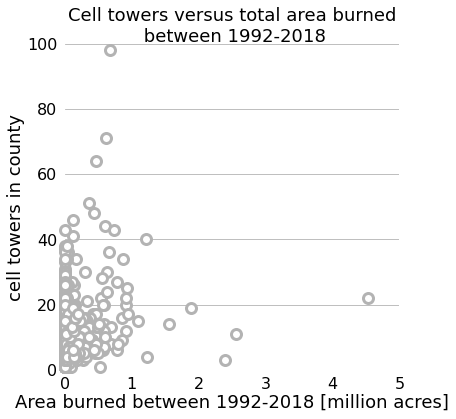

In [5]:
# which county most acres burned
with plt.style.context('plot_style.mplstyle'):
    
    fig, ax = plt.subplots(figsize=(6, 6), facecolor='white')

    ax.scatter(df_final["TOTAL_FIRE_AREA"]/1_000_000, df_final["N_TOWERS"],
               marker='o',
               s=100,
               linewidth=3,
               color=(1,1,1,1),
               edgecolor=[0.7,0.7,0.7],
               clip_on=False,
               zorder=2,)
    
    # set axis limits and tick marks
    ax.set_ylim([0, 100])
    ax.set_yticks(np.arange(0, 120, 20))
    ax.set_xlim([0, 5])

    # axis label
    ax.set_xlabel("Area burned between 1992-2018 [million acres]")
    ax.set_ylabel("cell towers in county")
    
    ax.set_title("Cell towers versus total area burned\n between 1992-2018")

### Which county has over 4 million acres burned over this period?

In [6]:
filt = df_final["TOTAL_FIRE_AREA"] == df_final["TOTAL_FIRE_AREA"].max()
df_final.loc[filt]

,index,STATE,COUNTY,MEAN_FIRE_AREA,TOTAL_FIRE_AREA,MAX_FIRE_AREA,MIN_FIRE_AREA,N_TOWERS,STATE_CNTY_FIPS,SAMPLEDLANDWATER_ACRES,FOREST_ACRES,ABOVEGRDBIOMASSTREES_SHRTTON,TOTALCARBON_SHRTTON,SHAPE_Length,SHAPE_Area,geometry
1842,1842,NV,ELKO,1475.079743,4529969.89,238462.6,0.01,22,32007,11009834.0,1.156089e+06,1.129806e+07,3.458697e+07,9.567581,4.779229,"MULTIPOLYGON (((-114.77493 42.00040, -114.7638..."


### Which county has nearly 100 cell towers?

In [7]:
filt = df_final["N_TOWERS"] == df_final["N_TOWERS"].max()
df_final.loc[filt]

,index,STATE,COUNTY,MEAN_FIRE_AREA,TOTAL_FIRE_AREA,MAX_FIRE_AREA,MIN_FIRE_AREA,N_TOWERS,STATE_CNTY_FIPS,SAMPLEDLANDWATER_ACRES,FOREST_ACRES,ABOVEGRDBIOMASSTREES_SHRTTON,TOTALCARBON_SHRTTON,SHAPE_Length,SHAPE_Area,geometry
149,149,AZ,MARICOPA,36.901345,672859.13199,248310.0,0.001,98,04013,5903507.0,75412.390242,466231.019963,2.098777e+06,8.182736,2.314202,"MULTIPOLYGON (((-111.66859 33.20475, -111.6686..."


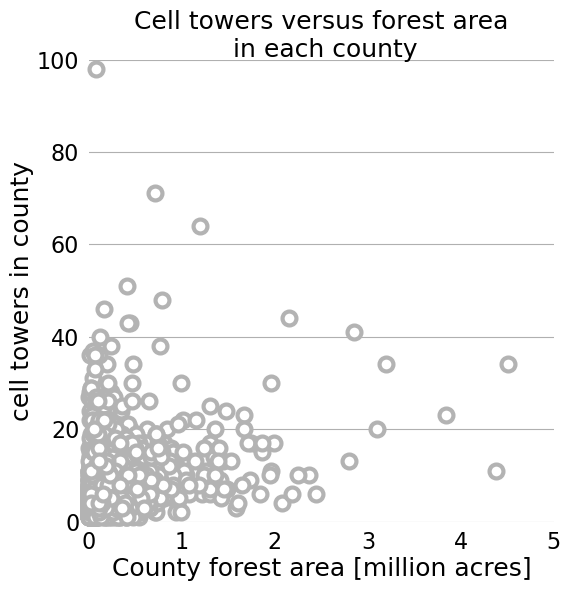

In [8]:
# which county most acres burned
with plt.style.context('plot_style.mplstyle'):
    fig, ax = plt.subplots(figsize=(6, 6), facecolor='white')

    ax.scatter(df_final["FOREST_ACRES"]/1_000_000, df_final["N_TOWERS"],
               marker='o',
               s=100,
               linewidth=3,
               color=(1,1,1,1),
               edgecolor=[0.7,0.7,0.7],
               clip_on=False,
               zorder=2,)
    
    # set axis limits and tick marks
    ax.set_ylim([0, 100])
    ax.set_yticks(np.arange(0, 120, 20))
    ax.set_xlim([0, 5])

    # axis label
    ax.set_xlabel("County forest area [million acres]")
    ax.set_ylabel("cell towers in county")
    
    ax.set_title("Cell towers versus forest area\n in each county")


### which counties have over 4 million acres of forest?

In [9]:
filt = df_final["FOREST_ACRES"] >= 4_000_000
df_final.loc[filt]

,index,STATE,COUNTY,MEAN_FIRE_AREA,TOTAL_FIRE_AREA,MAX_FIRE_AREA,MIN_FIRE_AREA,N_TOWERS,STATE_CNTY_FIPS,SAMPLEDLANDWATER_ACRES,FOREST_ACRES,ABOVEGRDBIOMASSTREES_SHRTTON,TOTALCARBON_SHRTTON,SHAPE_Length,SHAPE_Area,geometry
144,144,AZ,COCONINO,50.198494,878222.65,58630.0,0.01,34,04005,11943128.0,4.502483e+06,9.363439e+07,1.618333e+08,12.668366,4.821744,"MULTIPOLYGON (((-110.75068 37.00319, -110.7506..."
639,639,ID,IDAHO,332.675211,2561266.45,115659.0,0.01,11,16049,5441563.0,4.374558e+06,2.010685e+08,3.048728e+08,9.844874,2.550728,"MULTIPOLYGON (((-114.35799 46.66885, -114.3577..."


# 5. Next Steps
- Focus on specific forests and identify regions that have and don't have 4G/5G converage
- [FCC 4G LTE Coverage Map](https://fcc.maps.arcgis.com/apps/webappviewer/index.html?id=6c1b2e73d9d749cdb7bc88a0d1bdd25b) provides maps of 4G LTE mobile broadband coverage across the US for various carriers. 
- USDA provides estimates of [forest boundaries](https://data.fs.usda.gov/geodata/edw/datasets.php?dsetCategory=boundaries)
- satellite retrievals can also be used to estimate forested regions.
- Instead of LTE, may satellite internet is an option. Would need to find a dataset of satellite internet coverage and availabilty. 